## 1. About the Question and Objective

**The Problem:**
We are tasked with exploring the limitations of the Euler method by applying it to the Airy equation, a second-order ordinary differential equation given by:

$$\frac{d^2x}{dt^2} = t \cdot x(t)$$

We need to solve this initial-value problem numerically over the time interval $t \in [-30, 2]$. 

**Tasks:**
1. Integrate the equation using the standard forward Euler method with varying numbers of subdivisions (steps): $n = 1000, 3000, 5000$, and $10000$.
2. Solve the same equation using a sophisticated built-in solver, specifically `scipy.integrate.solve_ivp` using the **Radau** method.
3. Plot the Euler solutions alongside the Radau solution on the same graph for comparison.
4. Observe the discrepancy between the simple Euler approximations and the highly accurate Radau solution.

**Objective:**
The primary objective is to visually and analytically demonstrate the limitations of the Euler method—such as error accumulation, poor handling of oscillatory behavior, and potential instability. This will highlight why more advanced numerical methods are essential for certain types of differential equations.

## 2. Mathematical Analysis

**The Airy Equation:**
The given differential equation is a second-order linear ordinary differential equation (ODE) known as the Airy equation:

$$\frac{d^2x}{dt^2} = t \cdot x(t)$$

To solve this numerically using standard methods like Euler's or `scipy.integrate.solve_ivp`, we must first reduce this second-order ODE into a system of two first-order ODEs. 

**Reduction to First-Order System:**
Let us define a new variable, $v$, which represents the first derivative of $x$ with respect to $t$:

$$v = \frac{dx}{dt}$$

Taking the derivative of $v$ with respect to $t$ gives us the second derivative of $x$, which we know from our original equation is $t \cdot x$:

$$\frac{dv}{dt} = \frac{d^2x}{dt^2} = t \cdot x$$

Now, we have a system of two coupled first-order ODEs:

1. $$\frac{dx}{dt} = v$$
2. $$\frac{dv}{dt} = t \cdot x$$

Let our state vector be $\mathbf{Y} = [x, v]^T$. The system can be written as:

$$\frac{d\mathbf{Y}}{dt} = f(t, \mathbf{Y}) = \begin{bmatrix} v \\ t \cdot x \end{bmatrix}$$

**Euler's Method Formulation:**
The forward Euler method updates the state vector iteratively using the first derivative. Given a step size $h = \frac{t_{end} - t_{start}}{n}$, the update equations for our specific system from step $i$ to $i+1$ are:

$$t_{i+1} = t_i + h$$
$$x_{i+1} = x_i + h \cdot v_i$$
$$v_{i+1} = v_i + h \cdot (t_i \cdot x_i)$$

**Analytical Expectations (Why Euler might fail):**
For $t < 0$, the Airy equation takes the form $x'' + |t|x = 0$, which resembles a simple harmonic oscillator but with a time-varying frequency. The solutions here are highly oscillatory. For $t > 0$, the equation $x'' - tx = 0$ yields solutions that grow or decay exponentially. 

The forward Euler method is an explicit, first-order method. It is notoriously poor at handling highly oscillatory problems over long integration times because it introduces "artificial energy" into the system, causing the amplitude of the oscillations to grow artificially. We expect that even with a large number of subdivisions ($n = 10000$), the Euler method will struggle to track the true phase and amplitude of the oscillations compared to a robust implicit method like Radau.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [1]:
# Defining the ODE system for solve_ivp
# Y = [x, v], where v = dx/dt
def airy_system(t, Y):
    x, V = Y
    return [V,t*x]


# Defining Euler Method Implementation
def euler_airy(t_start, t_end, Y0, n):

    t = np.linspace(t_start,t_end,n+1)
    h = (t_start - t_end)/n
    x = np.zeros(n+1)
    v = np.zeros(n+1)

    # Initial conditions
    x[0],v[0] = Y0

    for i in range(n):
        x[i+1] = x[i] + h*v[i]
        v[i+1] = v[i] + h*(t[i]*x[i])

    return t,x

In [3]:
t_start = -30
t_end = 2
Y0 = [1.0 , 0.0]
n_values = [1000, 3000, 5000, 10000]

t_eval = np.linspace(t_start,t_end,10000)
sol_radau = solve_ivp(airy_system, [t_start, t_end], Y0, method='Radau', t_eval=t_eval)


y_min, y_max = np.min(sol_radau.y[0]), np.max(sol_radau.y[0])
y_padding = (y_max - y_min) * 0.5

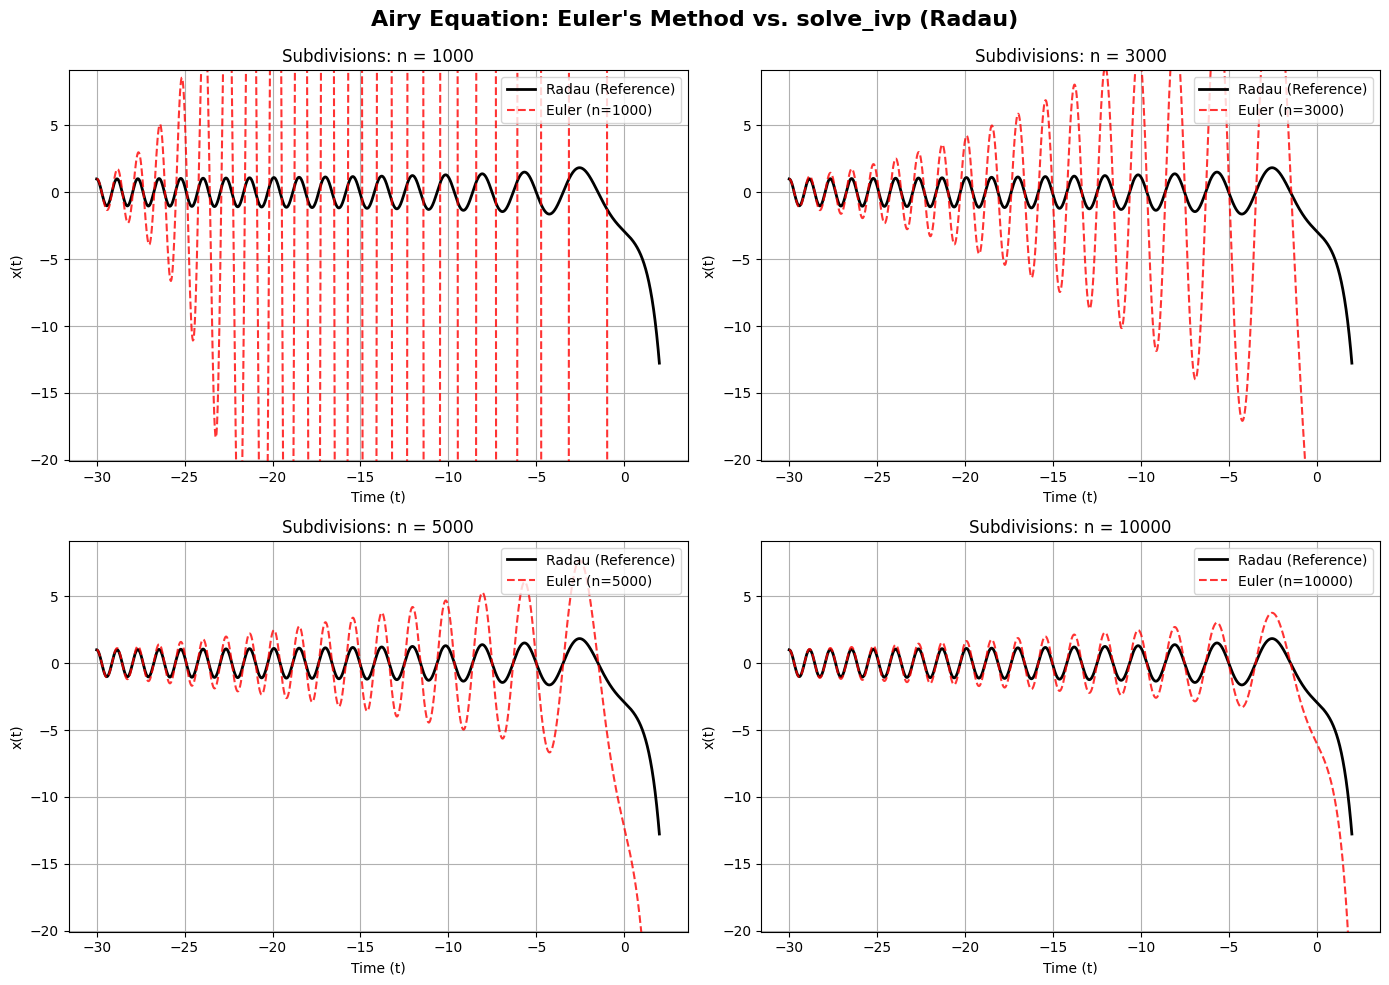

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Airy Equation: Euler's Method vs. solve_ivp (Radau)", fontsize=16, fontweight='bold')
axes = axes.flatten()

# Compute and plot for each subdivision 'n'
for idx, n in enumerate(n_values):
    t_euler, x_euler = euler_airy(t_start, t_end, Y0, n)
    
    ax = axes[idx]
    
    # Plot Radau reference
    ax.plot(sol_radau.t, sol_radau.y[0], 'k-', label='Radau (Reference)', linewidth=2)
    
    # Plot Euler
    ax.plot(t_euler, x_euler, 'r--', label=f'Euler (n={n})', alpha=0.8)
    
    ax.set_title(f"Subdivisions: n = {n}")
    ax.set_xlabel("Time (t)")
    ax.set_ylabel("x(t)")
    ax.legend(loc='upper right')
    ax.grid(True)
    
    # Constrain y-axis so the Euler divergence doesn't squash the reference curve
    ax.set_ylim(y_min - y_padding, y_max + y_padding)

plt.tight_layout()
plt.subplots_adjust(top=0.92) # Adjust title spacing
plt.show()

## 4. Observation and Conclusion

**Observations from the Graphs:**
* **Artificial Growth (Instability):** The most striking difficulty is that the Euler method introduces artificial energy into the system. While the true solution (Radau reference) maintains bounded oscillations for time t < 0, the amplitude of the Euler solution grows rapidly and unphysically. 
* **Effect of Step Size:** As we increase the number of subdivisions from n = 1000 to n = 10000 (effectively decreasing the step size), the Euler solution stays closer to the true solution for a longer period. However, even with 10,000 steps, the amplitude still noticeably diverges from the true solution as time progresses towards t = 0.
* **Phase Shift:** In addition to the amplitude error, the Euler method also begins to suffer from a phase shift, where the peaks and troughs of its oscillations no longer align perfectly with the true solution.
* **Complete Failure at the Boundary:** Near t = 0, where the behavior of the Airy equation transitions from oscillatory to exponential, the Euler method completely fails to capture the correct trajectory and drops off steeply.

**Conclusion:**
This exercise clearly demonstrates the severe limitations of the forward Euler method. Because it is a simple, first-order explicit method, it accumulates local truncation errors at every step. More importantly, its region of absolute stability is very small, making it highly unsuitable for integrating oscillatory systems over long time domains. 

To get a remotely accurate solution with the Euler method, the step size would have to be impractically microscopic, requiring massive computational time. This perfectly highlights why more sophisticated, higher-order, and often implicit methods (like the Radau method used by `scipy.integrate.solve_ivp`) are necessary. They employ adaptive step-sizing and error control to maintain stability and high accuracy without requiring millions of manual subdivisions.